# Store Sales Forecasting using Data Mining Techniques

In [157]:
pip install dask

Note: you may need to restart the kernel to use updated packages.


In [158]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/oil.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/sample_submission.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/holidays_events.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/stores.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/train.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/test.csv
/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/transactions.csv


In [159]:
oil = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/oil.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/stores.csv')
train  = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/test.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/transactions.csv')

In [160]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [161]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [162]:
##
# Step 1: Find the mode of the dcoilwtico column
mode_value = oil['dcoilwtico'].mode()[0]

# Step 2: Replace the missing values with the mode
oil['dcoilwtico'].fillna(mode_value)

# Step 3 (Optional): Verify if missing values are replaced
print(oil.isnull().sum())
# oil.to_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/Oil_Changed.csv')

date           0
dcoilwtico    43
dtype: int64


In [163]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [164]:
holidays.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [165]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [166]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [167]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [168]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [169]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [170]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [171]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [172]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [173]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [174]:
# Convert date columns to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

In [175]:
# Merge additional information into the train and test data
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

train = train.merge(holidays, on='date', how='left')
test = test.merge(holidays, on='date', how='left')

In [176]:
# Merge transactions data into train and test
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')

In [177]:
# Fill missing values without inplace=True to avoid chained assignment
train['onpromotion'] = train['onpromotion'].fillna(0)
test['onpromotion'] = test['onpromotion'].fillna(0)

train['dcoilwtico'] = train['dcoilwtico'].ffill()
test['dcoilwtico'] = test['dcoilwtico'].ffill()

train['transactions'] = train['transactions'].fillna(0)
test['transactions'] = test['transactions'].fillna(0)

In [178]:
print(train.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'type_y', 'locale',
       'locale_name', 'description', 'transferred', 'transactions'],
      dtype='object')


In [179]:
##
# Frequency encoding for 'family'
#train.family = pd.Categorical(train.family) Get the frequency of each unique category in 'family'
#train['family_freq'] = train.family.codes

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train['Family_Label'] = LE.fit_transform(train['family'])
train['City_Label'] = LE.fit_transform(train['city'])
train['State_Label'] = LE.fit_transform(train['state'])
train['Type_x_Label'] = LE.fit_transform(train['type_x'])
train['Locale_Label'] = LE.fit_transform(train['locale'])
train['Locale_Name_Label'] = LE.fit_transform(train['locale_name'])

test['Family_Label'] = LE.fit_transform(test['family'])
test['City_Label'] = LE.fit_transform(test['city'])
test['State_Label'] = LE.fit_transform(test['state'])
test['Type_x_Label'] = LE.fit_transform(test['type_x'])
test['Locale_Label'] = LE.fit_transform(test['locale'])
test['Locale_Name_Label'] = LE.fit_transform(test['locale_name'])

# Optionally, verify if encoding was applied correctly
print(train[['family', 'Family_Label','city', 'City_Label', 'state', 'State_Label', 'type_x', 'Type_x_Label']].head())
print(train[['family', 'Family_Label','city', 'City_Label', 'state', 'State_Label', 'type_x', 'Type_x_Label']].tail())

       family  Family_Label   city  City_Label      state  State_Label type_x  \
0  AUTOMOTIVE             0  Quito          18  Pichincha           12      D   
1   BABY CARE             1  Quito          18  Pichincha           12      D   
2      BEAUTY             2  Quito          18  Pichincha           12      D   
3   BEVERAGES             3  Quito          18  Pichincha           12      D   
4       BOOKS             4  Quito          18  Pichincha           12      D   

   Type_x_Label  
0             3  
1             3  
2             3  
3             3  
4             3  
                             family  Family_Label   city  City_Label  \
3054343                     POULTRY            28  Quito          18   
3054344              PREPARED FOODS            29  Quito          18   
3054345                     PRODUCE            30  Quito          18   
3054346  SCHOOL AND OFFICE SUPPLIES            31  Quito          18   
3054347                     SEAFOOD          

In [180]:
train.head()
# train.to_csv('../store-sales-time-series-forecasting-data/Changed_train.csv')

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,locale_name,description,transferred,transactions,Family_Label,City_Label,State_Label,Type_x_Label,Locale_Label,Locale_Name_Label
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Ecuador,Primer dia del ano,False,0.0,0,18,12,3,1,4
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,Ecuador,Primer dia del ano,False,0.0,1,18,12,3,1,4
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,Ecuador,Primer dia del ano,False,0.0,2,18,12,3,1,4
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,Ecuador,Primer dia del ano,False,0.0,3,18,12,3,1,4
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,Ecuador,Primer dia del ano,False,0.0,4,18,12,3,1,4


In [181]:
# Selecting features and target variable   
features = ['store_nbr', 'Family_Label', 'City_Label', 'State_Label', 'cluster', 'onpromotion', 'dcoilwtico', 'transactions', 'Type_x_Label']
X_train = train[features]
y_train = train['sales']
X_test_main = test[features]

In [182]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


# LightGBM Model

In [183]:
# Initialize the LightGBM model
lgb_train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.3,
    'verbosity': -1,
    'random_state': 42
}

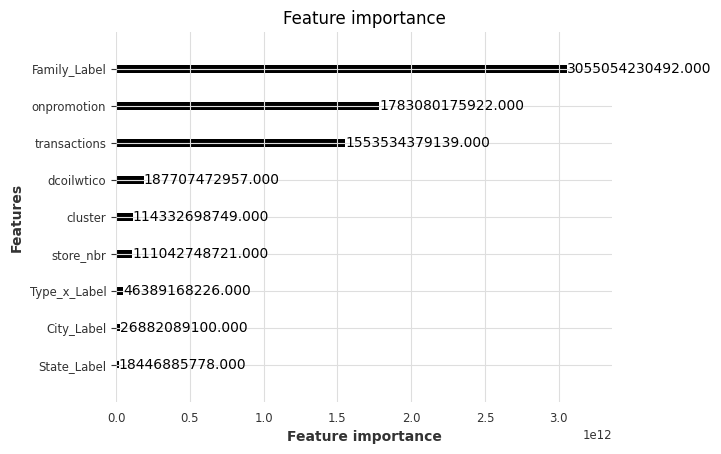

Validation RMSE: 281.87522379278784


In [184]:
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=100)
test['sales'] = lgb_model.predict(X_test_main)

# Display feature importance
lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain')
plt.show()

# Evaluate the model on a subset of the training data (optional)
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
lgb_train_data_subset = lgb.Dataset(X_train_subset, label=y_train_subset)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data_subset)

# Train the model with validation
lgb_model = lgb.train(params, lgb_train_data_subset, num_boost_round=100, valid_sets=[lgb_train_data_subset, lgb_val_data])

# Predictions on validation data
y_val_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}')

# Decision Tree

In [185]:
from sklearn.tree import DecisionTreeRegressor

# Create and train the model
regressor = DecisionTreeRegressor(random_state=0)
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_train_subset = X_train_subset.dropna()
y_train_subset = y_train_subset[X_train_subset.index]

regressor.fit(X_train_subset, y_train_subset)

y_pred = regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 536.08


# Random Forest

### Version 1

In [186]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
regressor = RandomForestRegressor(n_estimators=100,max_depth=2, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes=10, random_state=0)
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_train_subset = X_train_subset.dropna()
y_train_subset = y_train_subset[X_train_subset.index]

regressor.fit(X_train_subset, y_train_subset)

# Predict
y_pred = regressor.predict(X_test)

# Calculate RMSE
y_train_pred = regressor.predict(X_train_subset)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 1215.82


### Version 2 (Fine-tuning the Model)

In [187]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
regressor = RandomForestRegressor(n_estimators=50, max_depth=2, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes=10, random_state=42)
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_train_subset = X_train_subset.dropna()
y_train_subset = y_train_subset[X_train_subset.index]

regressor.fit(X_train_subset, y_train_subset)

# Predict
y_pred = regressor.predict(X_test)

# Calculate RMSE
y_train_pred = regressor.predict(X_train_subset)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 1215.69


### Version 3 (Further Fine-tuning)

In [188]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
regressor = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=15, min_samples_leaf=10, max_leaf_nodes=15, random_state=42)
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_train_subset = X_train_subset.dropna()
y_train_subset = y_train_subset[X_train_subset.index]

regressor.fit(X_train_subset, y_train_subset)

# Predict
y_pred = regressor.predict(X_test)

# Calculate RMSE
y_train_pred = regressor.predict(X_train_subset)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 796.37


# XGBoost Model

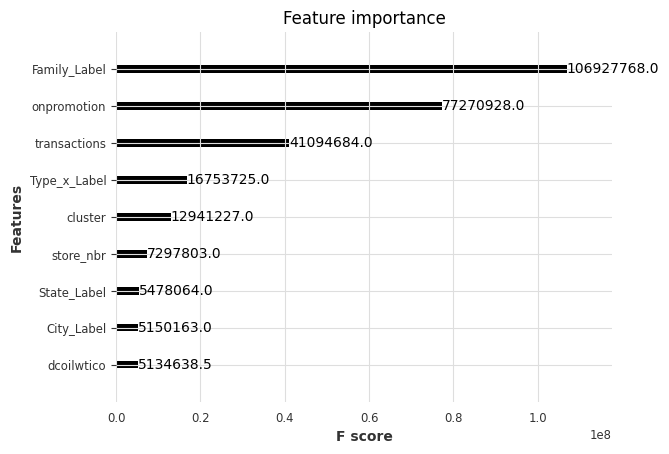

Root Mean Squared Error: 278.76507590693643


In [189]:
import xgboost as xgb

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 1,
    'n_estimators': 1000,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42
}

X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train_subset, y_train_subset)

# Display feature importance
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.show()

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Make predictions on the test set
test['sales'] = xgb_model.predict(X_test_main)

# HistGradient Boosting Model

In [190]:
from sklearn.ensemble import HistGradientBoostingRegressor as hgbr

# Split the data
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create HistGradientBoostingRegressor with custom parameters
params = {
    'max_iter': 100,
    'learning_rate': 0.1,
    'max_leaf_nodes': 31,
    'min_samples_leaf': 20,
    'l2_regularization': 0.0,
    'random_state': 42
}

hist_model = hgbr(**params)

# Fit the model
hist_model.fit(X_train_subset, y_train_subset)

# Make predictions
y_pred = hist_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Make predictions on the test set
test['sales'] = hist_model.predict(X_test_main)

Root Mean Squared Error: 340.7512498059339


# CatBoost Model

In [191]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [192]:
from catboost import CatBoostRegressor

# Assuming X_train, X_test, y_train_subset, and y_test are Pandas DataFrames or Series
# Convert Pandas DataFrames/Series to NumPy arrays
# X_train = train[features]
# y_train = train['sales']
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_subset_np = X_train_subset.to_numpy()  # Use .to_numpy() for Pandas DataFrames
X_test_np = X_test.to_numpy()
y_train_subset_np = y_train_subset.to_numpy()
y_test_np = y_test.to_numpy()

# Ensure that y_train_subset_np has the same number of samples as X_train_np
y_train_subset_np = y_train_subset_np[:X_train_subset_np.shape[0]]  # Trim if necessary

# Check their shapes to confirm
print("Shape of X_train:", X_train_subset_np.shape)
print("Shape of y_train_subset:", y_train_subset_np.shape)

# Define CatBoost model with missing value handling
cat_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    loss_function='RMSE',
    verbose=0
)

# Fit the model and make predictions
cat_model.fit(X_train_subset_np, y_train_subset_np)  # CatBoost handles nulls automatically
y_pred_cat = cat_model.predict(X_test_np)

# Calculate RMSE
rmse_cat = np.sqrt(mean_squared_error(y_test_np, y_pred_cat))
print(f"CatBoost RMSE: {rmse_cat}")

Shape of X_train: (2443478, 9)
Shape of y_train_subset: (2443478,)
CatBoost RMSE: 428.9647942614736


# Ensemble Boosting

In [193]:
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
import torch

X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ensure X_train_subset and X_test are NumPy arrays
if isinstance(X_train_subset, torch.Tensor):
    X_train_subset = X_train_subset.numpy()
if isinstance(X_test, torch.Tensor):
    X_test = X_test.numpy()

# Ensure y_train_subset and y_test are NumPy arrays
if isinstance(y_train_subset, torch.Tensor):
    y_train_subset = y_train_subset.numpy()
if isinstance(y_test, torch.Tensor):
    y_test = y_test.numpy()

# Flatten data if needed
if len(X_train_subset.shape) == 3:
    X_train_subset = X_train_subset.reshape(X_train_subset.shape[0], -1)
if len(X_test.shape) == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_subset = scaler.fit_transform(X_train_subset)
X_test = scaler.transform(X_test)

# Check shapes of training labels and test labels
print(f"Shape of y_train_subset: {y_train_subset.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Define individual models for the ensemble
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=5, verbose=0)

# Create a Voting Regressor for single-output tasks
voting_regressor = VotingRegressor([('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)])

# Fit the ensemble model on single-output training data
voting_regressor.fit(X_train_subset, y_train_subset)

# Make predictions on test data
y_pred_ensemble = voting_regressor.predict(X_test)

# Calculate RMSE for single-output regression
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print(f"Ensemble RMSE: {rmse_ensemble}")

Shape of y_train_subset: (2443478,)
Shape of y_test: (610870,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 2443478, number of used features: 9
[LightGBM] [Info] Start training from score 359.383665
Ensemble RMSE: 371.4140431715112


# AutoRegressive (AR) Model

In [127]:
from statsmodels.tsa.ar_model import AutoReg

# Splitting the data into train and test sets
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Since AutoReg is a time series model, we fit only on y_train (ignoring X for this case)
# We need to choose a lag value based on the nature of the time series

# Fit the AutoRegressive model
lags = 5
hold_back = 25
trend = 'ct'

model = AutoReg(y_train_subset, lags=lags, hold_back=hold_back, trend=trend)
model_fit = model.fit()

# Make predictions on the test set
y_pred = model_fit.predict(start=len(y_train_subset), end=len(y_train_subset) + len(y_test) - 1, dynamic=False)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1365.8229141489976


# Moving Average (MA) Model

In [128]:
from statsmodels.tsa.arima.model import ARIMA

# Splitting the data into train and test sets
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Fit a Moving Average model
# Since MA model doesn't use the features X, we only use y for fitting
p = 0  # Number of autoregressive terms
d = 0  # Number of differencing terms (to make the data stationary)
q = 1  # Number of moving average terms
model = ARIMA(y_train_subset, order=(p, d, q))  # MA part only, no AR or differencing
model_fit = model.fit()

# Make predictions on the test set
y_pred = model_fit.predict(start=len(y_train_subset), end=len(y_train_subset) + len(y_test) - 1, dynamic=False)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1373.3756376727792


# ARIMA Model

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ARIMA RMSE: 260314.42012343148
ARIMA Predictions:  2016-09-12    858942.671465
2016-09-13    803682.664951
2016-09-14    756529.586706
2016-09-15    749150.704613
2016-09-16    815168.487687
                  ...      
2017-08-11    822622.302337
2017-08-12    822622.302337
2017-08-13    822622.302337
2017-08-14    822622.302337
2017-08-15    822622.302337
Freq: D, Name: predicted_mean, Length: 338, dtype: float64


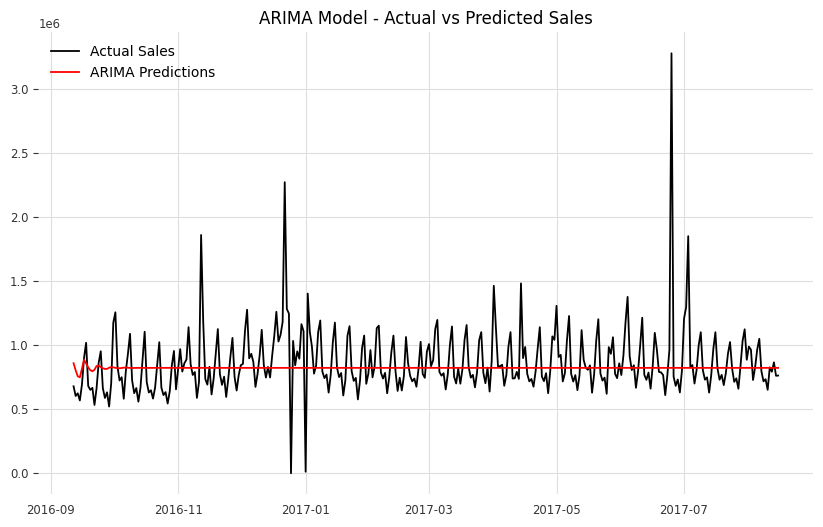

In [129]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Ensure 'date' is the index and properly formatted
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

# Aggregate sales by date (adjust 'D' based on the frequency of your data)
sales_data = train['sales'].resample('D').sum()

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(sales_data) * 0.8)
train_data, test_data = sales_data[:train_size], sales_data[train_size:]

# Fit ARIMA model (use (p, d, q) based on prior analysis)
model_arima = ARIMA(train_data, order=(5, 1, 0))  # Adjust (p, d, q) as needed
model_fit_arima = model_arima.fit()

# Forecast for the test period
start = len(train_data)
end = len(train_data) + len(test_data) - 1
forecast_arima = model_fit_arima.predict(start=start, end=end, typ='levels')

# Calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(test_data, forecast_arima))
print(f"ARIMA RMSE: {rmse_arima}")

# Print predictions
print("ARIMA Predictions: ", forecast_arima)

# Optional: Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label='Actual Sales')
plt.plot(test_data.index, forecast_arima, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs Predicted Sales')
plt.legend()
plt.show()

# kNN Model

In [130]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

# Split the data
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fill missing values in X_train_subset and X_test
imputer = SimpleImputer(strategy='mean')
X_train_subset = imputer.fit_transform(X_train_subset)
X_test = imputer.transform(X_test)

# Standardize the features for KNN
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test)

# Define KNN regressor
knn_params = {
    'n_neighbors': 3,
    'weights': 'uniform',
    'algorithm': 'auto',
    'p': 2
}

knn_model = KNeighborsRegressor(**knn_params)

# Fit the model
knn_model.fit(X_train_subset_scaled, y_train_subset)

# Make predictions
y_pred = knn_model.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 423.6525720383859


# LSTM Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - loss: 1114889.5000 - val_loss: 905563.1250
Epoch 2/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - loss: 887073.6875 - val_loss: 852246.3125
Epoch 3/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - loss: 834280.8750 - val_loss: 815409.5625
Epoch 4/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - loss: 813730.4375 - val_loss: 794418.4375
Epoch 5/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - loss: 790319.2500 - val_loss: 780149.8125
Epoch 6/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - loss: 781573.7500 - val_loss: 769185.6875
Epoch 7/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 111s 2ms/step - loss: 778380.9375 - val_loss: 761174.1250
Epoch 8/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 111s 2ms/step - loss: 761936.6250 - val_loss: 753595.6875
Epoch 9/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - loss: 752868.3125 - val_loss: 746770.1250
Epoch 10/10
61087/61087 ━━━━━━━━━━━━━━━━━━━━ 110s 2ms/step - loss: 759973.7500 - 

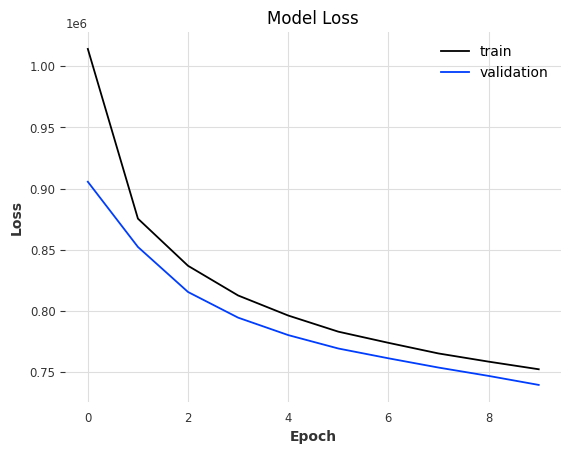

In [131]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Scale the features to the range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train.fillna(0))

# Reshape the data for LSTM input (samples, time steps, features)
# Here we use a single time step for simplicity; adjust as necessary for your data.
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_subset.shape[1], X_train_subset.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))       # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Plot training & validation loss values
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# If you want to make predictions on new data (assuming new_data is preprocessed)
# new_data_scaled = scaler.transform(new_data)
# new_data_scaled = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))
# predictions = model.predict(new_data_scaled)

# Bi-directional LSTM Model

In [152]:
train  = pd.read_csv('/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/train.csv')

train['date'] = pd.to_datetime(train['date'])
# Merge additional information into the train and test data
train = train.merge(stores, on='store_nbr', how='left')

train = train.merge(oil, on='date', how='left')

train = train.merge(holidays, on='date', how='left')

train = train.merge(transactions, on=['date', 'store_nbr'], how='left')

# Fill missing values without inplace=True to avoid chained assignment
train['onpromotion'] = train['onpromotion'].fillna(0)

train['dcoilwtico'] = train['dcoilwtico'].ffill()

train['transactions'] = train['transactions'].fillna(0)

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train['Family_Label'] = LE.fit_transform(train['family'])
train['City_Label'] = LE.fit_transform(train['city'])
train['State_Label'] = LE.fit_transform(train['state'])
train['Type_x_Label'] = LE.fit_transform(train['type_x'])
train['Locale_Label'] = LE.fit_transform(train['locale'])
train['Locale_Name_Label'] = LE.fit_transform(train['locale_name'])

# Optionally, verify if encoding was applied correctly
print(train[['family', 'Family_Label','city', 'City_Label', 'state', 'State_Label', 'type_x', 'Type_x_Label']].head())
print(train[['family', 'Family_Label','city', 'City_Label', 'state', 'State_Label', 'type_x', 'Type_x_Label']].tail())

       family  Family_Label   city  City_Label      state  State_Label type_x  \
0  AUTOMOTIVE             0  Quito          18  Pichincha           12      D   
1   BABY CARE             1  Quito          18  Pichincha           12      D   
2      BEAUTY             2  Quito          18  Pichincha           12      D   
3   BEVERAGES             3  Quito          18  Pichincha           12      D   
4       BOOKS             4  Quito          18  Pichincha           12      D   

   Type_x_Label  
0             3  
1             3  
2             3  
3             3  
4             3  
                             family  Family_Label   city  City_Label  \
3054343                     POULTRY            28  Quito          18   
3054344              PREPARED FOODS            29  Quito          18   
3054345                     PRODUCE            30  Quito          18   
3054346  SCHOOL AND OFFICE SUPPLIES            31  Quito          18   
3054347                     SEAFOOD          

Found duplicates. Resolving...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.7317 - val_loss: 1.0681
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5313 - val_loss: 0.9447
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4846 - val_loss: 1.1047
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4459 - val_loss: 0.9000
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4608 - val_loss: 1.3647
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4533 - val_loss: 0.9996
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4374 - val_loss: 0.8892
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4998 - val_loss: 0.8493
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4263 - val_loss: 0.7863
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3814 - val_loss: 0.7310
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3888 - val_loss: 0.8456
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3855 - val_l

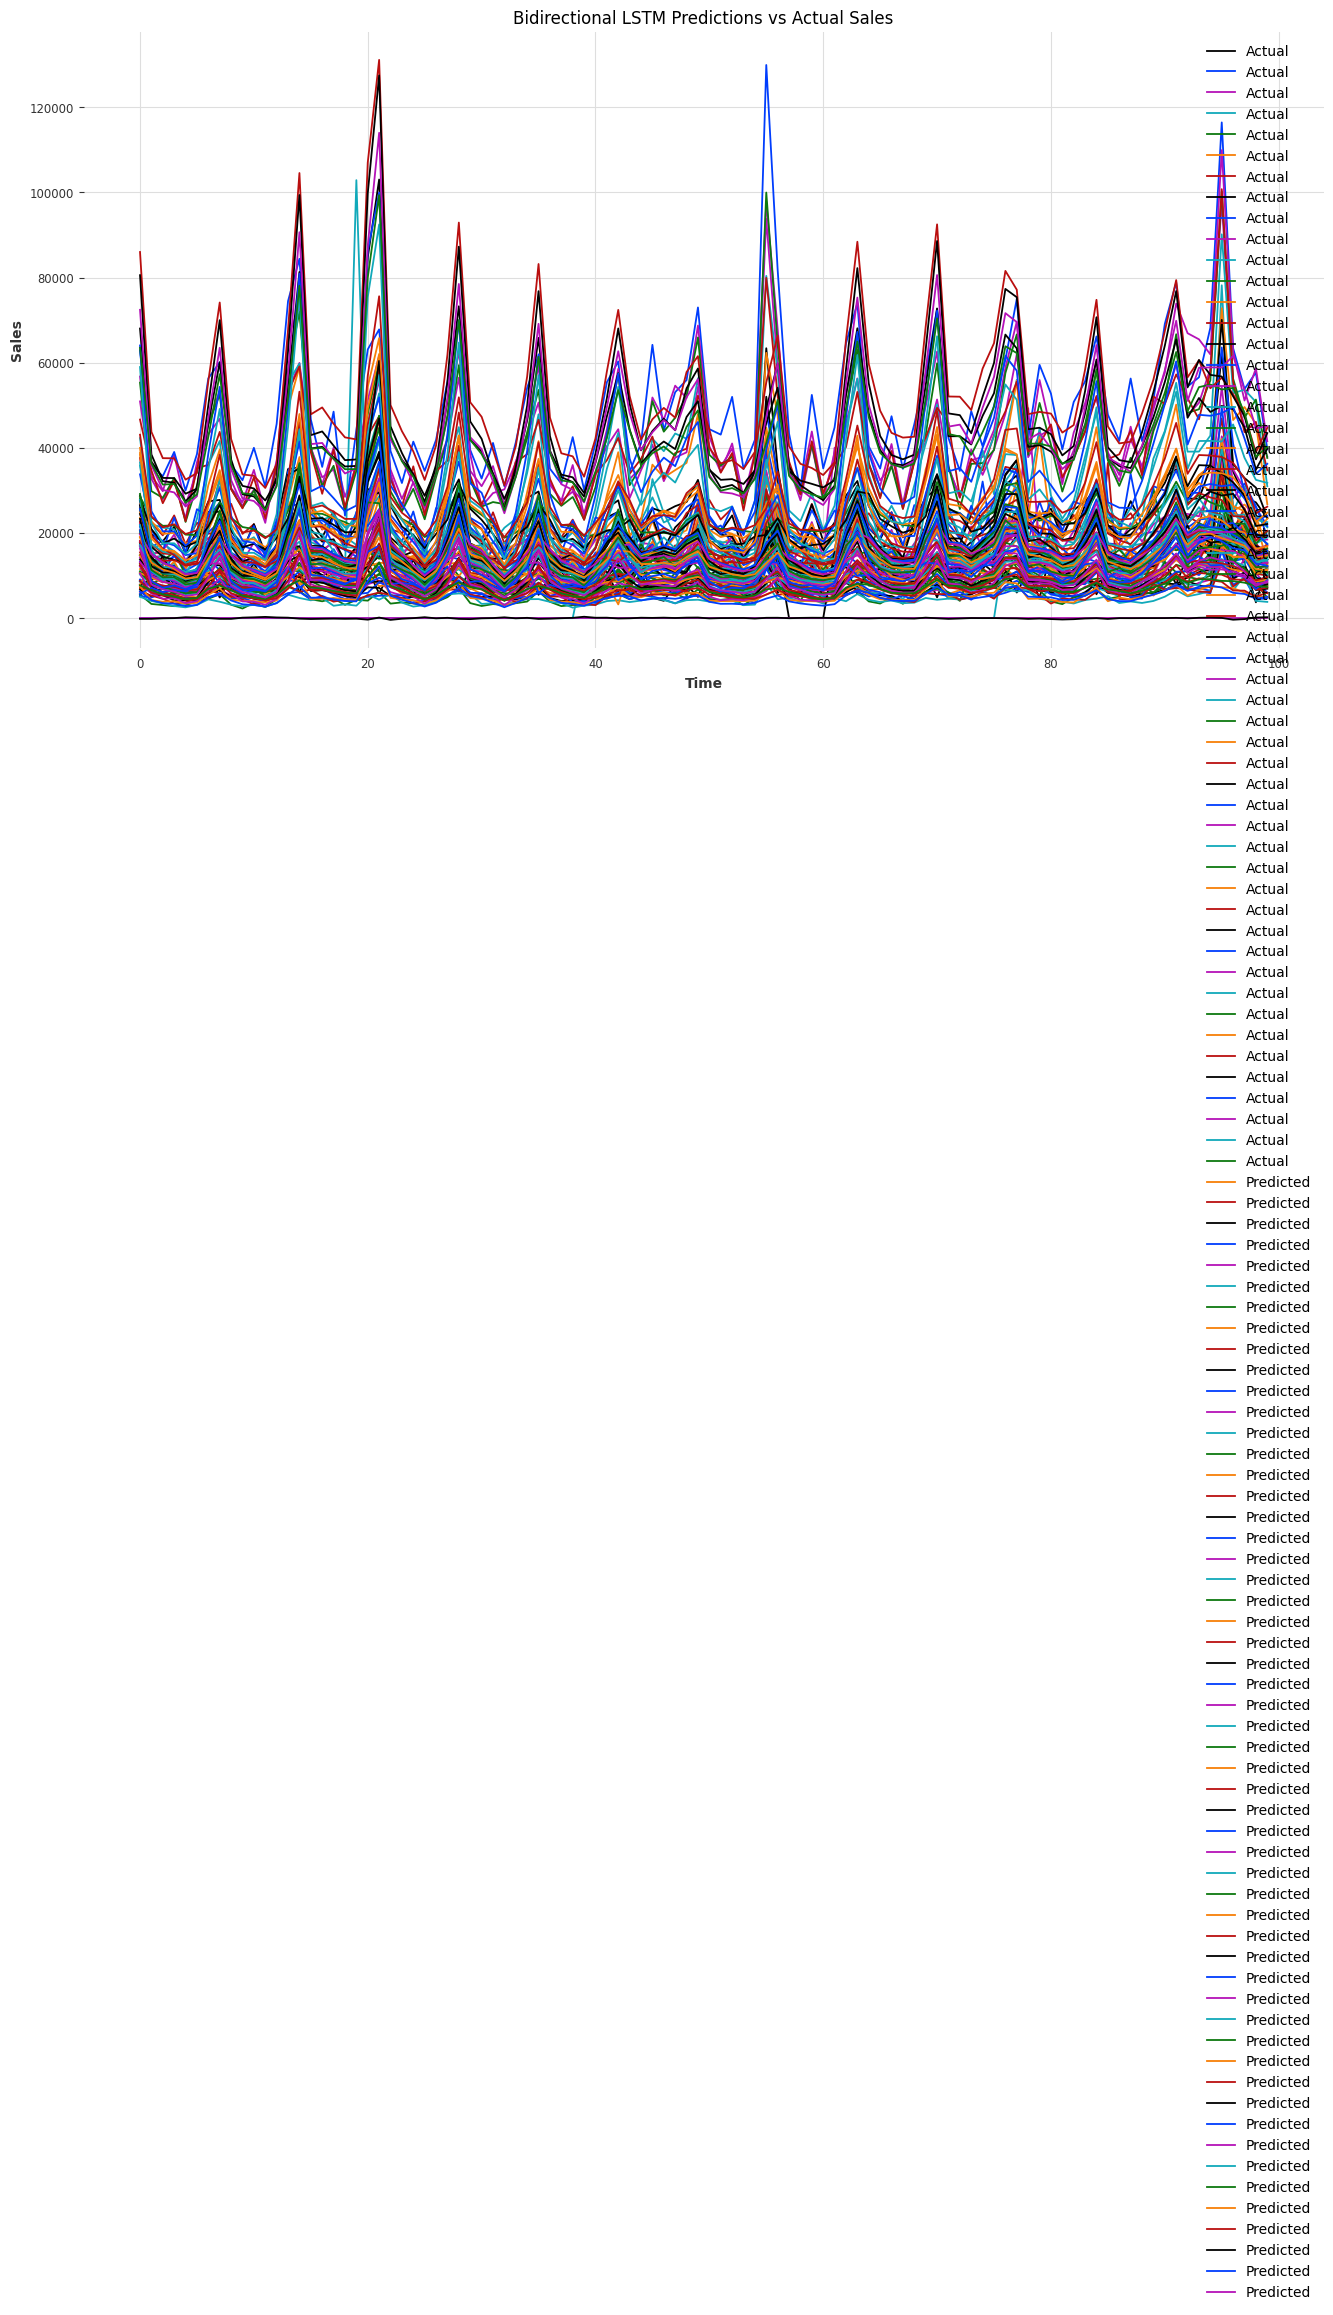

In [154]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, TimeDistributed

# Ensure they include 'date', 'store_nbr', and 'sales'

# Convert 'date' to datetime and sort
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(by=['store_nbr', 'date'])

# Check and resolve duplicates
duplicate_entries = train[train.duplicated(subset=['date', 'store_nbr'], keep=False)]
if not duplicate_entries.empty:
    print("Found duplicates. Resolving...")
    train = train.groupby(['date', 'store_nbr'], as_index=False)['sales'].sum()

# Create a pivot table for time-series format
sales_pivot = train.pivot(index='date', columns='store_nbr', values='sales').fillna(0)

# Normalize the data
scaler = StandardScaler()
sales_normalized = scaler.fit_transform(sales_pivot)

# Create sequences for LSTM input
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Define time steps
time_steps = 30  # Use the last 30 days for prediction
X, y = create_sequences(sales_normalized, time_steps)

# Split into train and test sets
split_index = int(0.8 * len(X))  # Using an 80-20 split
X_train_bi_lstm, X_test = X[:split_index], X[split_index:]
y_train_bi_lstm, y_test = y[:split_index], y[split_index:]

# Build the Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(X_train_bi_lstm.shape[1], X_train_bi_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train_bi_lstm.shape[1])  # Output layer matches the number of stores
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_bi_lstm, y_train_bi_lstm, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling for evaluation
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Bidirectional LSTM Root Mean Squared Error: {rmse}")

# Plot predictions vs actual
plt.figure(figsize=(16, 8))
plt.plot(y_test_original[:100], label='Actual')
plt.plot(y_pred_original[:100], label='Predicted')
plt.title('Bidirectional LSTM Predictions vs Actual Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# GRU Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,550 (103.71 KB)

 Trainable params: 26,550 (103.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0672 - mae: 0.1855 - val_loss: 0.0169 - val_mae: 0.0976
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0099 - mae: 0.0727 - val_loss: 0.0119 - val_mae: 0.0815
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0086 - mae: 0.0653 - val_loss: 0.0110 - val_mae: 0.0793
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0078 - mae: 0.0631 - val_loss: 0.0100 - val_mae: 0.0749
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0077 - mae: 0.0611 - val_loss: 0.0088 - val_mae: 0.0710
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0073 - mae: 0.0591 - val_loss: 0.0094 - val_mae: 0.0742
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - mae: 0.0587 - val_loss: 0.0079 - val_mae: 0.0666
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - mae: 0.0542 - val_loss: 0.0079 - val_mae: 0.0665
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.006

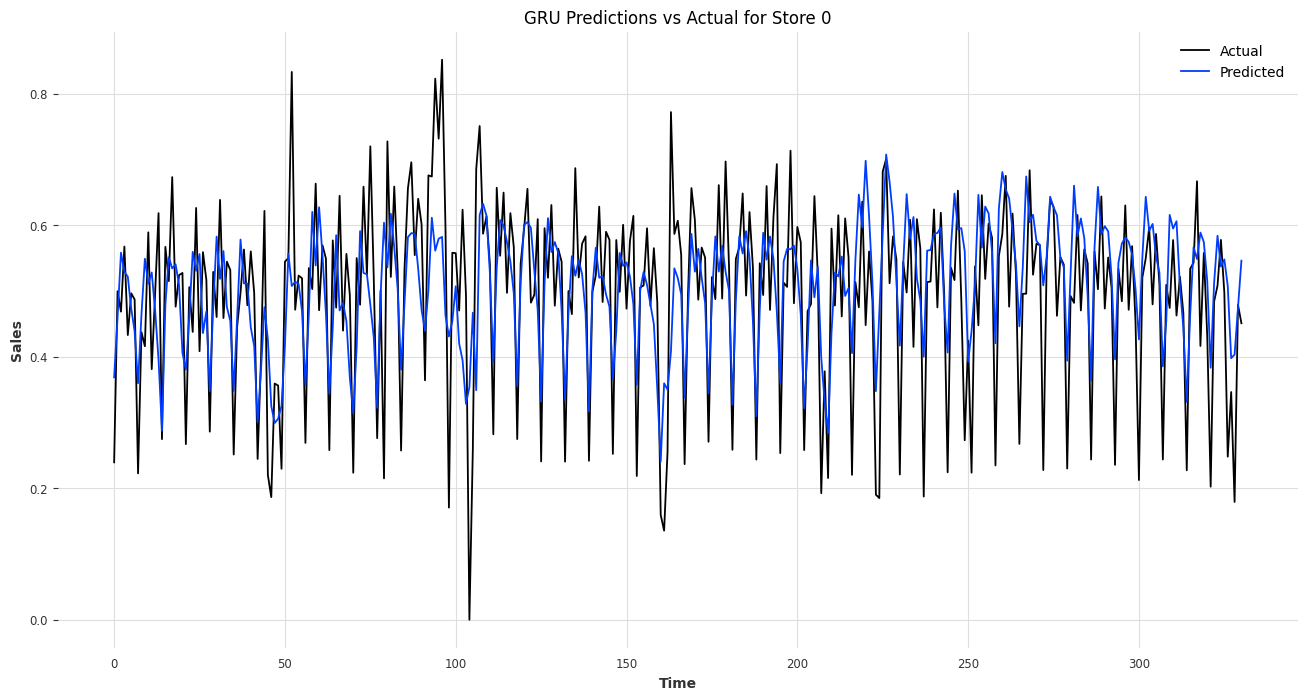

In [134]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Load the dataset
file_path = '/kaggle/input/store-sales-forecasting-data/store-sales-time-series-forecasting-data/train.csv'  # Replace with your file path
train_data = pd.read_csv(file_path)

# Step 1: Preprocess data
train_data['date'] = pd.to_datetime(train_data['date'])

# Encode categorical variables
store_encoder = LabelEncoder()
family_encoder = LabelEncoder()
train_data['store_nbr_encoded'] = store_encoder.fit_transform(train_data['store_nbr'])
train_data['family_encoded'] = family_encoder.fit_transform(train_data['family'])

# Aggregate data by store for time series modeling
pivot_data = train_data.pivot_table(
    index='date',
    columns='store_nbr_encoded',
    values='sales',
    aggfunc='sum',
    fill_value=0
)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivot_data)

# Step 2: Prepare sequences for GRU
sequence_length = 30  # Number of days for each input sequence

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Sequence of seq_length days
        y.append(data[i + seq_length])   # Next day's data
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 3: Define the GRU model
model = Sequential([
    GRU(64, activation='tanh', input_shape=(sequence_length, X_train_subset.shape[2]), return_sequences=False),
    Dense(y_train_subset.shape[1])  # Output layer with the same number of stores as features
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

# Step 4: Train the model
history = model.fit(X_train_subset, y_train_subset, epochs=20, batch_size=32, validation_split=0.1)

# Step 5: Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Step 6: Make predictions
predictions = model.predict(X_test)

# Optional: Inverse transform the predictions to original scale if needed
predicted_sales = scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print (f"RMSE : {rmse}")

import matplotlib.pyplot as plt

store_index = 0  # Change this index to visualize other stores
plt.figure(figsize=(16, 8))
plt.plot(y_test[:, store_index], label='Actual')
plt.plot(predictions[:, store_index], label='Predicted')
plt.title(f"GRU Predictions vs Actual for Store {store_index}")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Deep Belief Network (DBN)

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_train_subset, X_test, y_train_subset, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_subset = torch.tensor(scaler.fit_transform(X_train_subset), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Convert y_train and y_test to NumPy arrays before PyTorch tensors
y_train_subset = torch.tensor(y_train_subset.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


# Define a DBN-like model with stacked RBMs and a fine-tuning step
class DBN(nn.Module):
    def __init__(self, input_dim):
        super(DBN, self).__init__()
        # Adjust the input dimension to match the number of features in X_train
        self.hidden1 = nn.Linear(input_dim, 100)
        self.hidden2 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        return self.output(x)

# Initialize the model with the correct input dimension
input_dim = X_train_subset.shape[1]
model = DBN(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

X_train_subset = torch.nan_to_num(X_train_subset, nan=0.0, posinf=1e6, neginf=-1e6)
X_test = torch.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_subset)
    loss = criterion(outputs, y_train_subset)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

Epoch [10/100], Loss: 1352150.8750
Epoch [20/100], Loss: 1297655.1250
Epoch [30/100], Loss: 1160809.8750
Epoch [40/100], Loss: 1043111.8750
Epoch [50/100], Loss: 989111.9375
Epoch [60/100], Loss: 950200.1250
Epoch [70/100], Loss: 934962.7500
Epoch [80/100], Loss: 932708.9375
Epoch [90/100], Loss: 931911.6875
Epoch [100/100], Loss: 931190.8750
Root Mean Square Error (RMSE): 954.59
